In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

In [2]:
iot_df = pd.read_csv('../data/IoT_processed_ready_data.csv')
iot_df

,pkts,bytes,dur,mean,stddev,sum,min,max,spkts,dpkts,...,proto_udp,state_CON,state_FIN,state_INT,state_REQ,state_RST,sport_category_registered,sport_category_well_known,dport_category_registered,dport_category_well_known
0,8,1980,7.056393,0.068909,0.068909,0.137818,0.000000,0.137818,5,3,...,False,False,False,False,False,True,False,False,False,True
1,8,2126,7.047852,0.064494,0.064494,0.128988,0.000000,0.128988,5,3,...,False,False,False,False,False,True,False,False,False,True
2,8,2024,7.047592,0.064189,0.064189,0.128378,0.000000,0.128378,5,3,...,False,False,False,False,False,True,False,False,False,True
3,8,2319,7.046841,0.063887,0.063887,0.127774,0.000000,0.127774,5,3,...,False,False,False,False,False,True,False,False,False,True
4,8,1983,7.046596,0.063579,0.063579,0.127157,0.000000,0.127157,5,3,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659244,6,434,0.023737,0.023737,0.000000,0.023737,0.023737,0.023737,3,3,...,False,False,False,False,False,True,True,False,False,True
3659245,6,434,0.013165,0.013165,0.000000,0.013165,0.013165,0.013165,3,3,...,False,False,False,False,False,True,True,False,False,True
3659246,6,434,0.000574,0.000574,0.000000,0.000574,0.000574,0.000574,3,3,...,False,False,False,False,False,True,True,False,False,True
3659247,31,5472,2.874302,2.874302,0.000000,2.874302,2.874302,2.874302,14,17,...,False,False,True,False,False,False,True,False,False,True


In [17]:
iot_df['attack'].value_counts()

attack
1    3658827
0        422
Name: count, dtype: int64

In [3]:
# splitting data into train dataset and test dataset
feature_cols = list(iot_df.columns)
feature_cols.remove('attack')
X = iot_df.loc[:, feature_cols]
y = iot_df.loc[:, 'attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
# downsampling of attack majority to have model learn more from non-attack flows
data = pd.concat([X_train, y_train], axis=1)

# downsampling majority class (attacks) to learn more about non-attack flows
class_majority = data[data['attack'] == 1]
class_minority = data[data['attack'] == 0]

# Downsample majority class
class_majority_downsampled = resample(class_majority,
                                      replace=False,  # Sample without replacement
                                      n_samples=10000, 
                                      random_state=42)  # Reproducible results

# Upsample minority class
class_minority_upsampled = resample(class_minority,
                                    replace=True,
                                    n_samples=1000, 
                                    random_state=42)

# Combine minority class and downsampled majority class
data_downsampled = pd.concat([class_majority_downsampled, class_minority_upsampled])

# Shuffle the data
data_downsampled = data_downsampled.sample(frac=1, random_state=42)  # Shuffle rows
data_downsampled

,pkts,bytes,dur,mean,stddev,sum,min,max,spkts,dpkts,...,state_CON,state_FIN,state_INT,state_REQ,state_RST,sport_category_registered,sport_category_well_known,dport_category_registered,dport_category_well_known,attack
3189724,15,900,13.962124,3.985050,0.825967,11.955149,2.976124,4.999301,15,0,...,False,False,True,False,False,False,False,False,True,1
1783335,2,308,10.057964,0.000000,0.000000,0.000000,0.000000,0.000000,2,0,...,False,False,False,True,False,True,False,False,True,1
1552519,7,420,24.687077,3.016106,1.741461,12.064425,0.000000,4.043417,7,0,...,False,False,True,False,False,True,False,False,True,1
1908635,1,154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,False,False,False,True,False,False,False,False,True,1
1446241,17,1020,25.524853,3.821292,1.910677,19.106459,0.000000,4.791091,17,0,...,False,False,True,False,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545647,7,890,42.526855,1.118711,1.784556,4.474843,0.000000,4.203700,6,1,...,False,False,False,False,True,True,False,False,True,1
2180719,7,890,12.106893,3.020202,0.063829,9.060605,2.959632,3.108456,6,1,...,False,False,False,False,True,False,False,False,True,1
293823,8,950,24.178272,0.012640,0.010578,0.063198,0.000000,0.025252,5,3,...,False,False,False,False,True,False,False,False,True,1
2096363,5,770,13.656963,2.390829,1.690572,7.172486,0.000000,3.586758,5,0,...,False,False,False,True,False,False,False,False,True,1


In [5]:
# new training dataset after downsampling of attack majority
X_train = data_downsampled.iloc[:, 0:-1]
y_train = data_downsampled.loc[:, 'attack']

In [6]:
# standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [7]:
# find best hyperparameter from logistic regression with l1 penalty and k-fold cross validation
logreg = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
param_grid = {'C': [0.01, 0.1, 1, 10]}  # List of values to try for parameter C
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000, penalty='l1',
                                          solver='saga'),
             param_grid={'C': [0.01, 0.1, 1, 10]}, scoring='accuracy')

In [8]:
# get best hyperparameter
best_C = grid_search.best_params_['C']

# Initialize the logistic regression model with the best hyperparameter
best_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=best_C)

# Fit the best model on the entire training data
best_logreg.fit(X_train, y_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       127
           1       1.00      1.00      1.00   1097648

    accuracy                           1.00   1097775
   macro avg       0.84      1.00      0.90   1097775
weighted avg       1.00      1.00      1.00   1097775



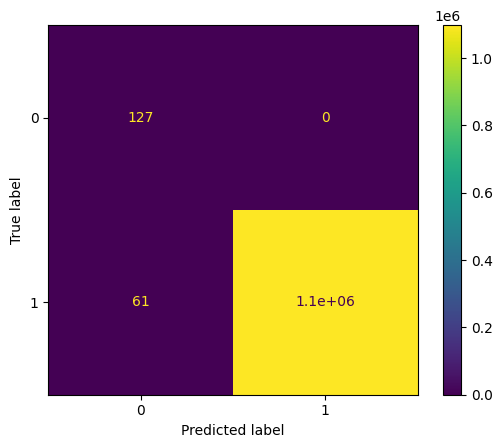

In [9]:
# Making predictions
y_pred = best_logreg.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels = best_logreg.classes_)
disp.plot()

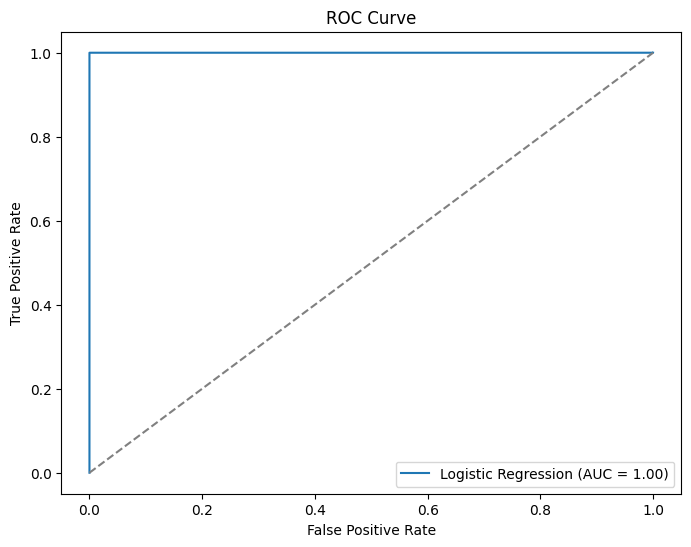

In [10]:
# roc curve for logistic regression
lr_probs = best_logreg.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = auc(lr_fpr, lr_tpr)
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [11]:
# XGBoost model hyperparameter tuning
xgboost_model = xgb.XGBClassifier(objective='binary:logistic')
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Example alpha values, adjust as needed
}
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']

# best alpha found through cross-validation
print("Best alpha:", best_alpha)

Best alpha: 0.01


In [12]:
# xgb model trained with best alpha
xgb_model = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.32      1.00      0.48       127
           1       1.00      1.00      1.00   1097648

    accuracy                           1.00   1097775
   macro avg       0.66      1.00      0.74   1097775
weighted avg       1.00      1.00      1.00   1097775



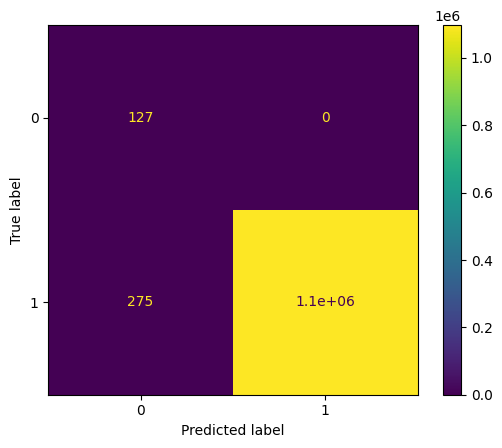

In [13]:
# xgboost model predictions
y_pred = xgb_model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels = best_logreg.classes_)
disp.plot()

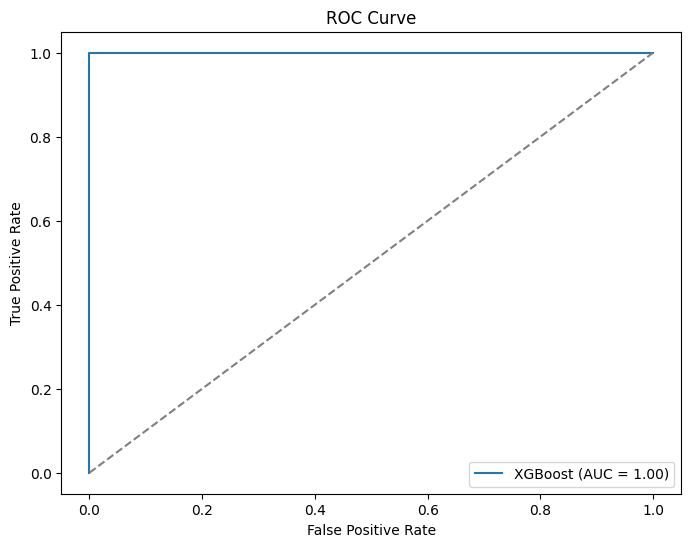

In [14]:
# roc curve for xgboost
xg_probs = xgb_model.predict_proba(X_test)[:, 1]
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs)
xg_auc = auc(xg_fpr, xg_tpr)
plt.figure(figsize=(8, 6))
plt.plot(xg_fpr, xg_tpr, label=f'XGBoost (AUC = {xg_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [15]:
# support vector machine hyperparameter tuning and implementation
param_grid = {'C': [0.1, 1, 10]}
svm = SVC(kernel='linear')
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
# print best parameter after tuning 
print(grid_search.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid_search.best_estimator_) 

{'C': 0.1}
SVC(C=0.1, kernel='linear')


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       127
           1       1.00      1.00      1.00   1097648

    accuracy                           1.00   1097775
   macro avg       0.67      1.00      0.75   1097775
weighted avg       1.00      1.00      1.00   1097775



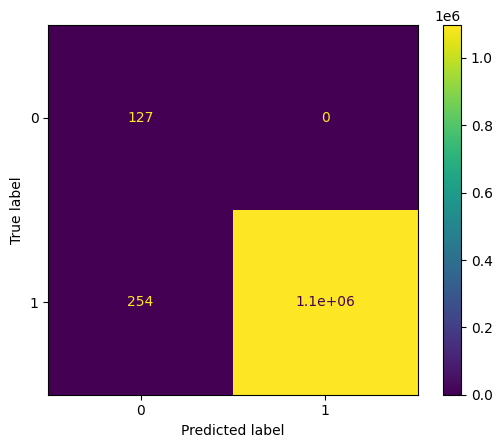

In [16]:
# SVM model evaluation
y_pred = grid_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels = best_logreg.classes_)

disp.plot()